In [121]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import plot_vaccine_by_state, alternativeModel

%reload_ext autoreload

def MAE(sol,tgt):
    assert(len(sol)==len(tgt))
    return np.sum(np.abs(sol-tgt))

def Deviation(sol,tgt):
    assert(len(sol)==len(tgt))
    return (sol-tgt)/tgt

def disparity(N,r,style=1):
    assert(style==1 or style==2)
    out = 0
    coef = 2/(N*(N-1))
    for i in range(N):
        for j in range(i+1,N):
            if style==1:
                out += np.abs(r[i]-r[j])
            elif style==2:
                out += (r[i]-r[j])**2
    return coef*out


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
df = pd.read_csv("Dataset/data_with_age_groups.csv")

N = len(df) # num. of locations
M = np.sum(df["Total_1"]) # total unit amount of resources
lam = 0.125

c = np.log(np.array(df["Distance"]))
o = np.zeros(N)
n = np.array(df["Population"])
age_1 = np.array(df["age_1"]); s_1 = age_1/n
age_2 = np.array(df["age_2"]); s_2 = age_2/n

y_raw = np.array(df["Total_1"])
r_raw = (o+y_raw)/(n*lam)
alpha_raw = np.min(r_raw)



PX_1 = N/M # P(X=1)
PX_0 = 1-PX_1 # P(X=0)

k_1 = 1 - 0.3  #1-VE (20-64)
k_2 = 1 - 0.35 #1-VE (>= 65)

p_1 = 1043/100000 #P(Y=1|Z=1)

p_1_0 = p_1*(1/(PX_0+PX_1*k_1))          #P(Y=1|X=0,Z=1)
p_1_1 = p_1_0 * k_1                      #P(Y=1|X=1,Z=1)

p_2 = 1411/100000 #P(Y=1|Z=2)

p_2_0 = p_2*(1/(PX_0+PX_1*k_2))           #P(Y=1|X=0,Z=2)
p_2_1 = p_2_0 * k_2                       #P(Y=1|X=1,Z=2)

p0 = p_1_0*s_1 + p_2_0*s_2 #P(Y=0|X=0)
p1 = p_1_1*s_1 + p_2_1*s_2 #P(Y=1|X=1)
Delta = (1-p1) - (1-p0)

eps = np.ones(N)*10
inv_p = 1/(1-p0+eps)

p = p_1*s_1 + p_2*s_2

In [123]:
print("P(Y=1|X=0,Z:20-64)=",round(p_1_0,4))
print("P(Y=1|X=0,Z:65+)=",round(p_2_0,4))
print("P(Y=1|Z:20-64)=",round(p_1,4))
print("P(Y=1|Z:65+)=",round(p_2,4))
print("P(Y=1)=",f"[{round(min(p),4)},{round(max(p),4)}]")
print("1/(1-P(Y=1|X=0)+eps)=",f"[{round(min(inv_p),4)},{round(max(inv_p),4)}]")

P(Y=1|X=0,Z:20-64)= 0.0104
P(Y=1|X=0,Z:65+)= 0.0141
P(Y=1|Z:20-64)= 0.0104
P(Y=1|Z:65+)= 0.0141
P(Y=1)= [0.008,0.009]
1/(1-P(Y=1|X=0)+eps)= [0.091,0.091]


In [137]:
beta=2*1e-1; 
gamma=1*1e-4; style=1
# 0.2 0.0001
lam = 0.125
rou=2.5*1e5; # used to be 2.5*1e5

disp_raw = disparity(N,r_raw,style)

print(f"min y_raw {min(y_raw)}, max y_raw {max(y_raw)}")
print("rou * disp_raw:",disp_raw*rou)

print("\nFirst term coef range (RW-1): [",round(min(beta*p),5),
      ",",round(max(beta*p),5),"]")
print("First term coef range (RW-2): [",round(min(beta*inv_p),5),
      ",",round(max(beta*inv_p),5),"]")
print("\nSecond term coef:",rou)
print("Third term coef range: [",round(min(gamma*c),5),
      ",",round(max(gamma*c),5),"]")


# y ~ 1e4 - 1e6
# first (third) term * y  ~  sum of 1e-3 * (1e4 to 1e6) = 1e2 to 1e3
# second term * disp ~ 1e-1 - 1e3
# first - second - third ~ -1e3 to 1e3

def objective(beta,rou,gamma,p,inv_p,disp,c,y):
    RW1 = (beta*p - gamma*c)@y - rou*disp 
    RW2 = (beta*inv_p - gamma*c)@y - rou*disp 
    return RW1,RW2

val_raw_RW1, val_raw_RW2 = objective(beta,
                                     rou,gamma,p,inv_p,
                                     disp_raw,c,y_raw)

min y_raw 21450.0, max y_raw 1323075.0
rou * disp_raw: 4121.562816121191

First term coef range (RW-1): [ 0.00159 , 0.00181 ]
First term coef range (RW-2): [ 0.01819 , 0.0182 ]

Second term coef: 250000.0
Third term coef range: [ 0.00048 , 0.00084 ]


In [138]:
y_RW1, val_RW1 = alternativeModel(N,M,c,o,n,lam,p,alpha_raw,
                     beta,rou,gamma, 
                     RW_style=1,
                     d_style=1,name=None,pout=False)

y_RW2, val_RW2 = alternativeModel(N,M,c,o,n,lam,p0,alpha_raw,
                     beta,rou,gamma, 
                     RW_style=2,eps=eps,
                     d_style=1,name=None,pout=False)

Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0


In [139]:

print("\nRW1 obj.val: ",val_RW1)

print("RW-1 raw data obj.val: ",val_raw_RW1)

# print((o+y_sol)/(n*lam))
print("RW-1 unassigned unit amount: ",M-np.sum(y_RW1))


r_RW1 = (o+y_RW1)/(n*lam)
disp_RW1 = disparity(N,r_RW1,style)

print(f"First term: RW-1 Model {beta*p@y_RW1}, raw {beta*p@y_raw}")
print(f"Second term: RW-1 Model {-1*rou*disp_RW1}, raw {-1*rou*disp_raw}")
print(f"Third term: baselineModel {-1*gamma*c@y_RW1}, raw {-1*gamma*c@y_raw}")

print(f"\nRW1 MAE % w.r.t. raw solution: ,{round(100*MAE(y_RW1,y_raw)/M,3)}%")
deviation = Deviation(y_RW1,y_raw)*100
print(f"Deviaiton: mean {round(np.mean(deviation),3)}%, sd {round(np.std(deviation),3)}%")



RW1 obj.val:  10142.78921890667
RW-1 raw data obj.val:  6041.564342268118
RW-1 unassigned unit amount:  0.0
First term: RW-1 Model 16481.011691972926, raw 16493.10099824647
Second term: RW-1 Model -1.020654510225304, raw -4121.562816121191
Third term: baselineModel -6337.251829128927, raw -6329.973839857159

RW1 MAE % w.r.t. raw solution: ,2.423%
Deviaiton: mean -2.23%, sd 5.29%


<Figure size 1200x400 with 0 Axes>

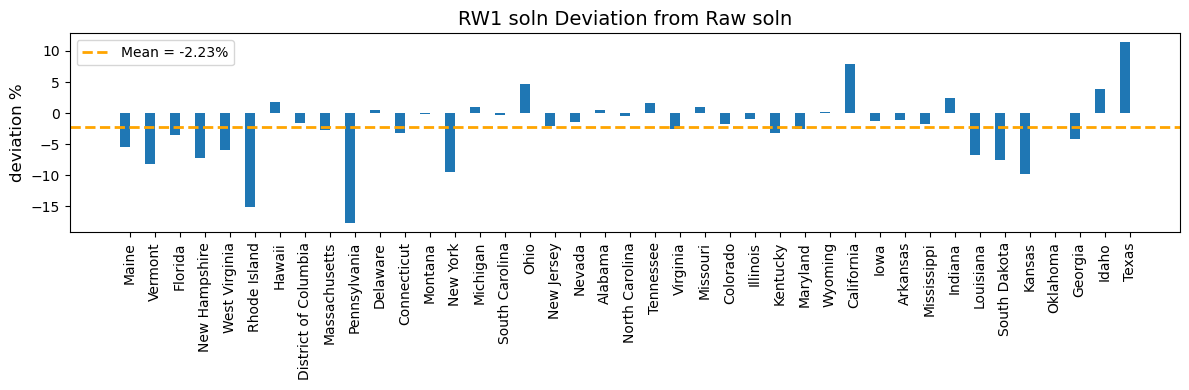

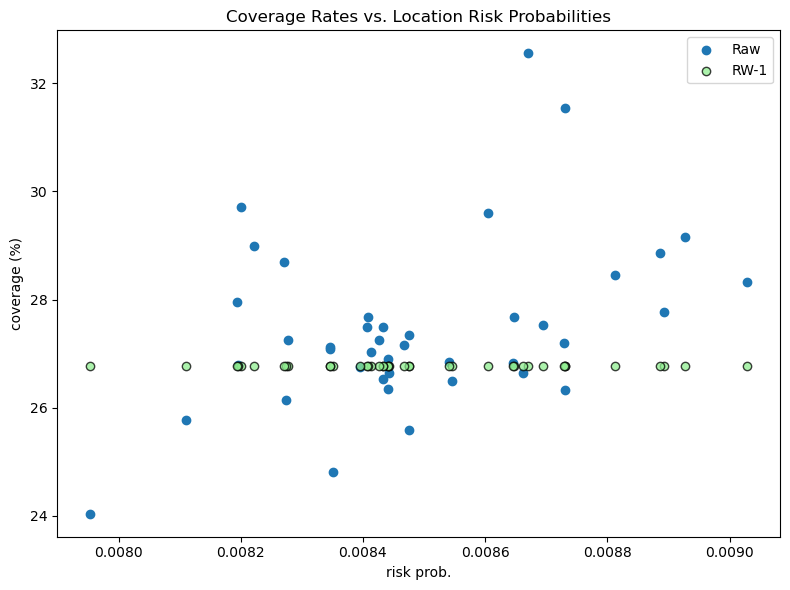

In [140]:
df["risk"] = p

df_sorted = df.sort_values(["risk"], ascending=False)

# ''''''
# # Deviation plot
# ''''''
plt.figure(figsize=(12, 4))
x = np.arange(len(df_sorted))        # positions for states
width = 0.4                          # bar width
fig, ax1 = plt.subplots(figsize=(12, 4))
 # Second y-axis
bars1 = ax1.bar(
    x - width/2,
    deviation,
    width)
mean_dev = np.mean(deviation)
ax1.axhline(
    y=mean_dev,
    linestyle="--",
    color="orange",
    linewidth=2,
    label=f"Mean = {mean_dev:.2f}%")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["State"], rotation=90)
# Axis labels
ax1.set_ylabel("deviation %",fontsize=12)
ax1.set_title(f"RW1 soln Deviation from Raw soln",fontsize=14)
plt.tight_layout()
plt.legend()
plt.show() 

''''''
# Coverage plot
''''''
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["risk"],r_raw*100,label="Raw")
plt.scatter(df_sorted["risk"],r_RW1*100,label="RW-1",
            color="lightgreen",edgecolors="black",alpha=0.75)
plt.xlabel("risk prob.")
plt.ylabel("coverage (%)")
plt.title("Coverage Rates vs. Location Risk Probabilities")
plt.tight_layout()
plt.legend()
plt.show()


In [141]:
print("\nRW2 obj.val: ",val_RW2)

print("RW-2 raw data obj.val: ",val_raw_RW2)

# print((o+y_sol)/(n*lam))
print("RW-2 unassigned unit amount: ",M-np.sum(y_RW2))


r_RW2 = (o+y_RW2)/(n*lam)
disp_RW2 = disparity(N,r_RW2,style)

print(f"First term: RW-2 Model {beta*inv_p@y_RW2}, raw {beta*inv_p@y_raw}")
print(f"Second term: RW-2 Model {-1*rou*disp_RW2}, raw {-1*rou*disp_raw}")
print(f"Third term: RW-2 Model {-1*gamma*c@y_RW2}, raw {-1*gamma*c@y_raw}")

print(f"\nRW2 MAE % w.r.t. raw solution: ,{round(100*MAE(y_RW2,y_raw)/M,3)}%")
deviation = Deviation(y_RW2,y_raw)*100
print(f"Deviaiton: mean {round(np.mean(deviation),3)}%, sd {round(np.std(deviation),3)}%")



RW2 obj.val:  171460.81627709224
RW-2 raw data obj.val:  167347.60215775573
RW-2 unassigned unit amount:  0.0
First term: RW-2 Model 177799.03875015856, raw 177799.13881373403
Second term: RW-2 Model -1.020654510225304, raw -4121.562816121191
Third term: RW-2 Model -6337.251829128927, raw -6329.973839857159

RW2 MAE % w.r.t. raw solution: ,2.423%
Deviaiton: mean -2.23%, sd 5.29%


<Figure size 1200x400 with 0 Axes>

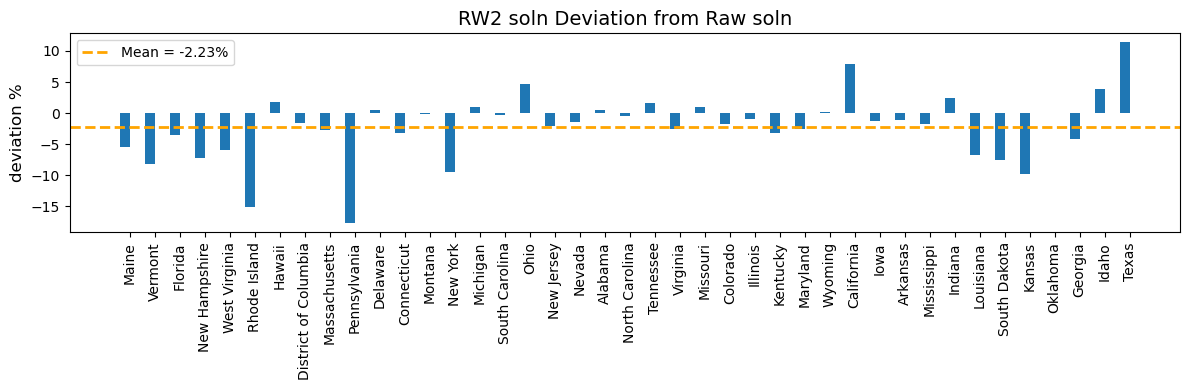

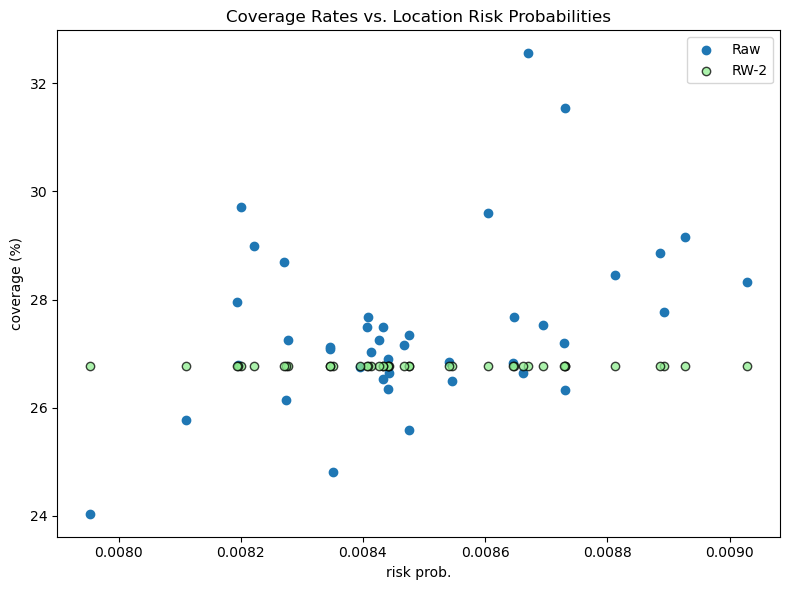

In [142]:
df["inverse_risk"] = inv_p

df_sorted = df.sort_values(["inverse_risk"], ascending=False)

# ''''''
# # Deviation plot
# ''''''
plt.figure(figsize=(12, 4))
x = np.arange(len(df_sorted))        # positions for states
width = 0.4                          # bar width
fig, ax1 = plt.subplots(figsize=(12, 4))
 # Second y-axis
bars1 = ax1.bar(
    x - width/2,
    deviation,
    width)
mean_dev = np.mean(deviation)
ax1.axhline(
    y=mean_dev,
    linestyle="--",
    color="orange",
    linewidth=2,
    label=f"Mean = {mean_dev:.2f}%")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["State"], rotation=90)
# Axis labels
ax1.set_ylabel("deviation %",fontsize=12)
ax1.set_title(f"RW2 soln Deviation from Raw soln",fontsize=14)
plt.tight_layout()
plt.legend()
plt.show() 

''''''
# Coverage plot
''''''
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["risk"],r_raw*100,label="Raw")
plt.scatter(df_sorted["risk"],r_RW1*100,label="RW-2",
            color="lightgreen",edgecolors="black",alpha=0.75)
plt.xlabel("risk prob.")
plt.ylabel("coverage (%)")
plt.title("Coverage Rates vs. Location Risk Probabilities")
plt.tight_layout()
plt.legend()
plt.show()


In [144]:
print(f"\nRW1 vs. RW2 MAE % w.r.t. raw solution: ,{round(100*MAE(y_RW1,y_RW2)/M,3)}%")
deviation = Deviation(y_RW1,y_RW2)*100
print(f"Deviaiton RW1 vs. RW2: mean {round(np.mean(deviation),3)}%, sd {round(np.std(deviation),3)}%")



RW1 vs. RW2 MAE % w.r.t. raw solution: ,0.0%
Deviaiton RW1 vs. RW2: mean 0.0%, sd 0.0%
